### Synthetic E-commerce Dataset

This notebook generates 20k rows that imitate e-commerce data including the following.

- Customer data
  - Membership flag
  - Past spending 
- Product data
  - Six types: "food", "eletronics", "medicine", "kichenware", "clothing", "furniture"
  - Three tiers: "cheap", "popular", "highend" 
- Order data
  - Quantity from 1 to 10
  - Discount applied
 
The win rate represents the probability of a given product being ordered. A random value between 0.0 and 1.0 is assigned to the win rate for each product, considering the attributes of the product. The price is also similarly populated but in different ranges.

The dataset is designed to demonstrate price sensitivity analyses and price optimizations, as shown in [this notebook](https://www.kaggle.com/code/qshick/conversion-sensitivity-model).
___

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
# Common settings
np.random.seed(2024)
SIZE = 20000

# Assign random values to create columns
# Boolean columns
membership_flag = np.random.randint(low=0, high=2, size=SIZE) # flag for the customer's membership status

# Integer columns
quantity = np.random.randint(low=1, high=11, size=SIZE) # 1 to 10 quantities for the order

# Float columns - Non-zero dollars
past_spending = [
    max(x, 0) for x in np.random.normal(loc=1000, scale=1000, size=SIZE).round(2)
]
discount = [
    max(x, 0) for x in np.random.normal(loc=0, scale=0.1, size=SIZE).round(2)
]

# Categorical columns
goods_type = np.random.choice(
    a=["food", "eletronics", "medicine", "kichenware", "clothing", "furniture"], 
    size=SIZE,
)
brand_tier = np.random.choice(
    a=["cheap", "popular", "highend"], 
    size=SIZE,
)

# Create dataframe with columns
df = pd.DataFrame({
    "id": np.arange(1, SIZE + 1, 1),
    "membership_flag": membership_flag,
    "past_spending": past_spending,
    "goods_type": goods_type,
    "brand_tier": brand_tier,
    "quantity": quantity,
    "discount": discount,
})
df.head()

,id,membership_flag,past_spending,goods_type,brand_tier,quantity,discount
0,1,0,1023.73,clothing,cheap,1,0.15
1,2,0,0.00,eletronics,highend,2,0.06
2,3,0,1873.31,clothing,highend,5,0.17
3,4,0,592.82,eletronics,popular,1,0.00
4,5,1,796.50,furniture,popular,1,0.09


In [3]:
def generate_win_rate(mu, sigma, random_state, lower=0, upper=1):
    """Draw a value at random from a normal distribution between 0.0 and 1.0"""
    return scipy.stats.truncnorm.rvs(
        (lower-mu) / sigma, 
        (upper-mu) / sigma, 
        loc=mu,
        scale=sigma,
        size=1, 
        random_state=random_state,
    )[0]

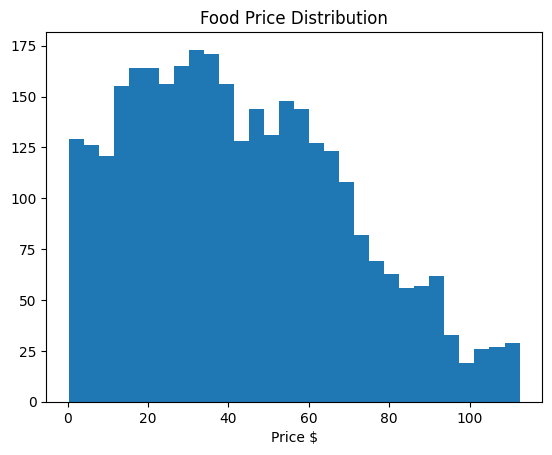

In [4]:
# Imitate prices by giving different price ranges for each category
df["price"] = df.apply(
    lambda x: generate_win_rate(50, 30, x["id"], lower=1, upper=75) if x["goods_type"] == "food"
    else generate_win_rate(75, 25, x["id"], lower=1, upper=150) if x["goods_type"] == "medicine"
    else generate_win_rate(60, 40, x["id"], lower=1, upper=80) if x["goods_type"] == "kichenware"
    else generate_win_rate(80, 50, x["id"], lower=1, upper=200) if x["goods_type"] == "clothing"
    else generate_win_rate(200, 50, x["id"], lower=1, upper=350) if x["goods_type"] == "eletronics"
    else generate_win_rate(300, 100, x["id"], lower=1, upper=500),  # furniture
    axis=1,
)
df["price"] = df.apply(
    lambda x: x["price"] * generate_win_rate(0.75, 0.25, x["id"], lower=0.5, upper=1.0) if x["brand_tier"] == "cheap"
    else x["price"] * generate_win_rate(1, 0.25, x["id"], lower=0.25, upper=1.25) if x["brand_tier"] == "popular"
    else x["price"] * generate_win_rate(1.25, 0.5, x["id"], lower=0.25, upper=1.5),  # high end
    axis=1,
)

plt.hist(df.loc[df["goods_type"] == "food", "price"], bins=30)
plt.title("Food Price Distribution")
plt.xlabel("Price $")
plt.show()

Actual Order Rate: 20.85%


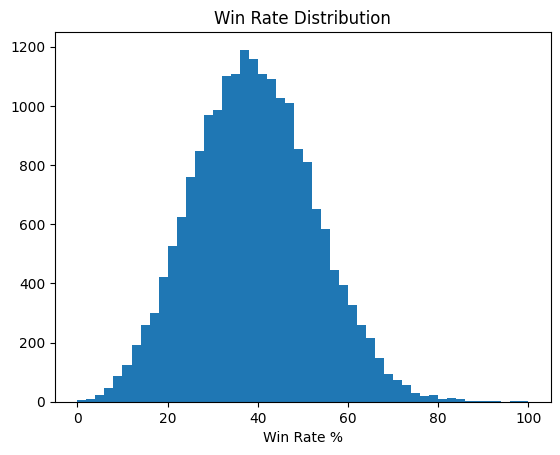

In [5]:
# Scale numeric columns to imitate win rates
df["past_spending_scaled"] = MinMaxScaler().fit_transform(df[["past_spending"]])
df["quantity_scaled"] = MinMaxScaler().fit_transform(df[["quantity"]])

# Imitate win rates
df["win_rate"] = (
    df["membership_flag"].apply(
        lambda x: np.random.uniform(low=0.5, high=1.0, size=1)[0] if x == 1
        else np.random.uniform(low=0.0, high=0.5, size=1)[0]
    ) +
    df["past_spending_scaled"] +
    df.apply(
        lambda x: generate_win_rate(0.35, 0.35, x["id"]) if x["goods_type"] == "food"
        else generate_win_rate(0.4, 0.15, x["id"]) if x["goods_type"] == "medicine"
        else generate_win_rate(0.2, 0.2, x["id"]) if x["goods_type"] == "kichenware"
        else generate_win_rate(0.2, 0.15, x["id"]) if x["goods_type"] == "clothing"
        else generate_win_rate(0.15, 0.1, x["id"]) if x["goods_type"] == "electronics"
        else generate_win_rate(0.1, 0.05, x["id"]), 
        axis=1,
    ) + 
    df.apply(
        lambda x: generate_win_rate(0.25, 0.25, x["id"]) if x["brand_tier"] == "cheap"
        else generate_win_rate(0.2, 0.1, x["id"]) if x["brand_tier"] == "popular"
        else generate_win_rate(0.1, 0.02, x["id"]),
        axis=1,
    ) +
    df["quantity_scaled"] +
    df["discount"]
)
df["win_rate"] = MinMaxScaler().fit_transform(df[["win_rate"]])
df["ordered"] = (df["win_rate"] >= 0.5).astype(int)

print(f"Actual Order Rate: {df.ordered.mean():.2%}")
plt.hist(df["win_rate"] * 100, bins=50)
plt.title("Win Rate Distribution")
plt.xlabel("Win Rate %")
plt.show()

In [6]:
training_data = pd.concat(
    [
        df[["ordered", "past_spending", "price", "quantity", "membership_flag"]],
        pd.get_dummies(df["goods_type"], prefix="goods_type").astype(int),
        pd.get_dummies(df["brand_tier"], prefix="brand_tier").astype(int),
    ],
    axis=1
)

# Save training data
training_data.to_csv("ecommerce_synthetic_data.csv", index=False)
training_data.head()

,ordered,past_spending,price,quantity,membership_flag,goods_type_clothing,goods_type_eletronics,goods_type_food,goods_type_furniture,goods_type_kichenware,goods_type_medicine,brand_tier_cheap,brand_tier_highend,brand_tier_popular
0,0,1023.73,52.378848,1,0,1,0,0,0,0,0,1,0,0
1,0,0.00,193.436500,2,0,0,1,0,0,0,0,0,1,0
2,0,1873.31,99.014038,5,0,1,0,0,0,0,0,0,1,0
3,0,592.82,355.935818,1,0,0,1,0,0,0,0,0,0,1
4,0,796.50,172.917876,1,1,0,0,0,1,0,0,0,0,1
